# Data Quality Impact on Healthcare Machine Learning

Oral Cancer Prediction Case Study | University of Colorado Boulder | DTSA 5509

## 1. Introduction

This project aims to develop a machine learning model to predict oral cancer diagnosis based on various risk factors, symptoms, and demographic information. The dataset contains 84,922 rows and 25 columns, including features like age, gender, tobacco use, alcohol consumption, HPV infection, and various oral symptoms.

However, during exploratory data analysis, I identified several issues with the dataset that would lead to misleading model performance, so now, this project will focus on how data quality affects model performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, classification_report, confusion_matrix, 
                            RocCurveDisplay, ConfusionMatrixDisplay)

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Initial Inspection

Here, I load in the full dataset and print out a summary of the columns and data types. Most of the columns are binary Yes/No features. There are no missing values in over 80K rows, which is sufficient data for this classification task. Overall, the dataset is structured well and looks to be very usable. The presence of post-diagnosis features like Cancer Stage is a red flag for predictive modeling.

In [2]:
# Load the full dataset
df_full = pd.read_csv("/kaggle/input/oral-cancer-prediction-dataset/oral_cancer_prediction_dataset.csv")
df_full = df_full.drop_duplicates()
df_full = df_full.set_index('ID') # Set ID as index, leaving 24 feature columns 

print(f"Dataset shape: {df_full.shape}")
print("\nFirst 5 rows of the dataset:")
df_full.head()

Dataset shape: (84922, 24)

First 5 rows of the dataset:


,Country,Age,Gender,Tobacco Use,Alcohol Consumption,HPV Infection,Betel Quid Use,Chronic Sun Exposure,Poor Oral Hygiene,Diet (Fruits & Vegetables Intake),...,Difficulty Swallowing,White or Red Patches in Mouth,Tumor Size (cm),Cancer Stage,Treatment Type,"Survival Rate (5-Year, %)",Cost of Treatment (USD),Economic Burden (Lost Workdays per Year),Early Diagnosis,Oral Cancer (Diagnosis)
ID,,,,,,,,,,,,,,,,,,,,,
1,Italy,36,Female,Yes,Yes,Yes,No,No,Yes,Low,...,No,No,0.000000,0,No Treatment,100.000000,0.00,0,No,No
2,Japan,64,Male,Yes,Yes,Yes,No,Yes,Yes,High,...,No,No,1.782186,1,No Treatment,83.340103,77772.50,177,No,Yes
3,UK,37,Female,No,Yes,No,No,Yes,Yes,Moderate,...,No,Yes,3.523895,2,Surgery,63.222871,101164.50,130,Yes,Yes
4,Sri Lanka,55,Male,Yes,Yes,No,Yes,No,Yes,Moderate,...,No,No,0.000000,0,No Treatment,100.000000,0.00,0,Yes,No
5,South Africa,68,Male,No,No,No,No,No,Yes,High,...,No,No,2.834789,3,No Treatment,44.293199,45354.75,52,No,Yes


In [3]:
# Basic data exploration
print("\nColumn information:")
df_full.info()

# Check unique values in each column
for col in df_full.columns:
    print(f'\n{col}\n{df_full[col].unique()}\n')


Column information:
<class 'pandas.core.frame.DataFrame'>
Index: 84922 entries, 1 to 84922
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Country                                   84922 non-null  object 
 1   Age                                       84922 non-null  int64  
 2   Gender                                    84922 non-null  object 
 3   Tobacco Use                               84922 non-null  object 
 4   Alcohol Consumption                       84922 non-null  object 
 5   HPV Infection                             84922 non-null  object 
 6   Betel Quid Use                            84922 non-null  object 
 7   Chronic Sun Exposure                      84922 non-null  object 
 8   Poor Oral Hygiene                         84922 non-null  object 
 9   Diet (Fruits & Vegetables Intake)         84922 non-null  object 
 10  Family History of 

## 3. Identifying Data Quality Issues

There are many features in the dataset that are not suitable for making diagnosis predictions. Features like Cancer Stage and Treatment Type effectively tell us that the patient has cancer, so they should not be used to infer a patient's diagnosis. Moreover, this information would not be available at the time of diagnosis in real-world scenarios. To prevent data leakage, these post-diagnosis features must be discarded.

In [4]:
# Identify post-diagnosis features that cause data leakage
leakage_features = ['Cancer Stage', 'Treatment Type', 'Survival Rate (5-Year, %)',
                'Cost of Treatment (USD)', 'Economic Burden (Lost Workdays per Year)', 
                'Tumor Size (cm)', 'Early Diagnosis']

# Create a clean dataset without post-diagnosis features
df_clean = df_full.drop(labels=leakage_features, axis=1)

print("Original dataset shape:", df_full.shape)
print("Clean dataset shape (without post-diagnosis features):", df_clean.shape)
print("\nRemoved post-diagnosis features that would cause data leakage:")
for feature in leakage_features:
    print(f"- {feature}")

Original dataset shape: (84922, 24)
Clean dataset shape (without post-diagnosis features): (84922, 17)

Removed post-diagnosis features that would cause data leakage:
- Cancer Stage
- Treatment Type
- Survival Rate (5-Year, %)
- Cost of Treatment (USD)
- Economic Burden (Lost Workdays per Year)
- Tumor Size (cm)
- Early Diagnosis


Now, the dataset only contains features that can be used for diagnosis like lifestyle, demographic, and risk factors as well as medical history and symptoms. The following EDA will help determine which high-information features to use and which to discard due to co-linearity or overall low-information gain.

## 4. EDA: Identifying Data Quality Issues

The dataset exhibits an unrealistic 50/50 split in oral cancer diagnoses, despite a [global age-standardized rate](https://www.wcrf.org/preventing-cancer/cancer-statistics/mouth-and-oral-cancer-statistics/) of 4 in 100,000. While feature imbalances initially appear more realistic, further EDA uncovers that every feature also displays a suspicious near 50/50 split when grouped by diagnosis. This artificial data does not align with real-world prevalence rates, limiting its predictive power for modeling. 

The patient population centers around 56 years of age, normally distributed, ([the averge age of people diagnosed with oral cancers is 64](https://www.cancer.org/cancer/types/oral-cavity-and-oropharyngeal-cancer/about/key-statistics.html)) and comes predominantly from eastern countries, with African countries underrepresented. These demographic limitations may restrict the model's generalizability as well as constrain insights into age-related risk factors.


Target variable distribution:
Oral Cancer (Diagnosis)
No     50.131886
Yes    49.868114
Name: proportion, dtype: float64


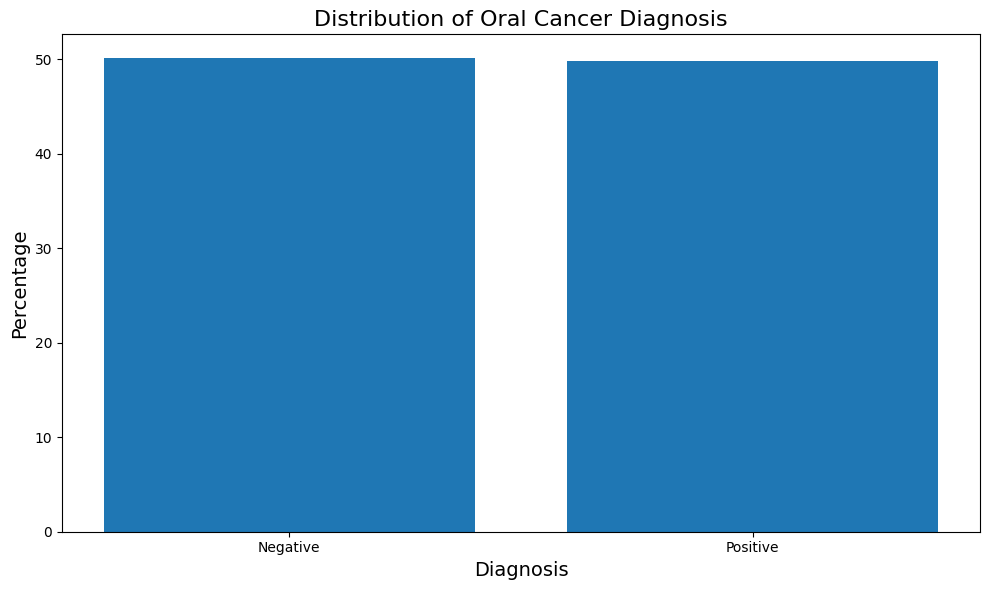

In [5]:
# Check the distribution of the target variable
print("\nTarget variable distribution:")
target_counts = df_full['Oral Cancer (Diagnosis)'].value_counts(normalize=True) * 100
print(target_counts)


# Plot target distribution
plt.figure(figsize=(10, 6))
plt.bar(['Negative', 'Positive'], [target_counts['No'], target_counts['Yes']])
plt.title('Distribution of Oral Cancer Diagnosis', fontsize=16)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Diagnosis', fontsize=14)
plt.tight_layout()
plt.show()

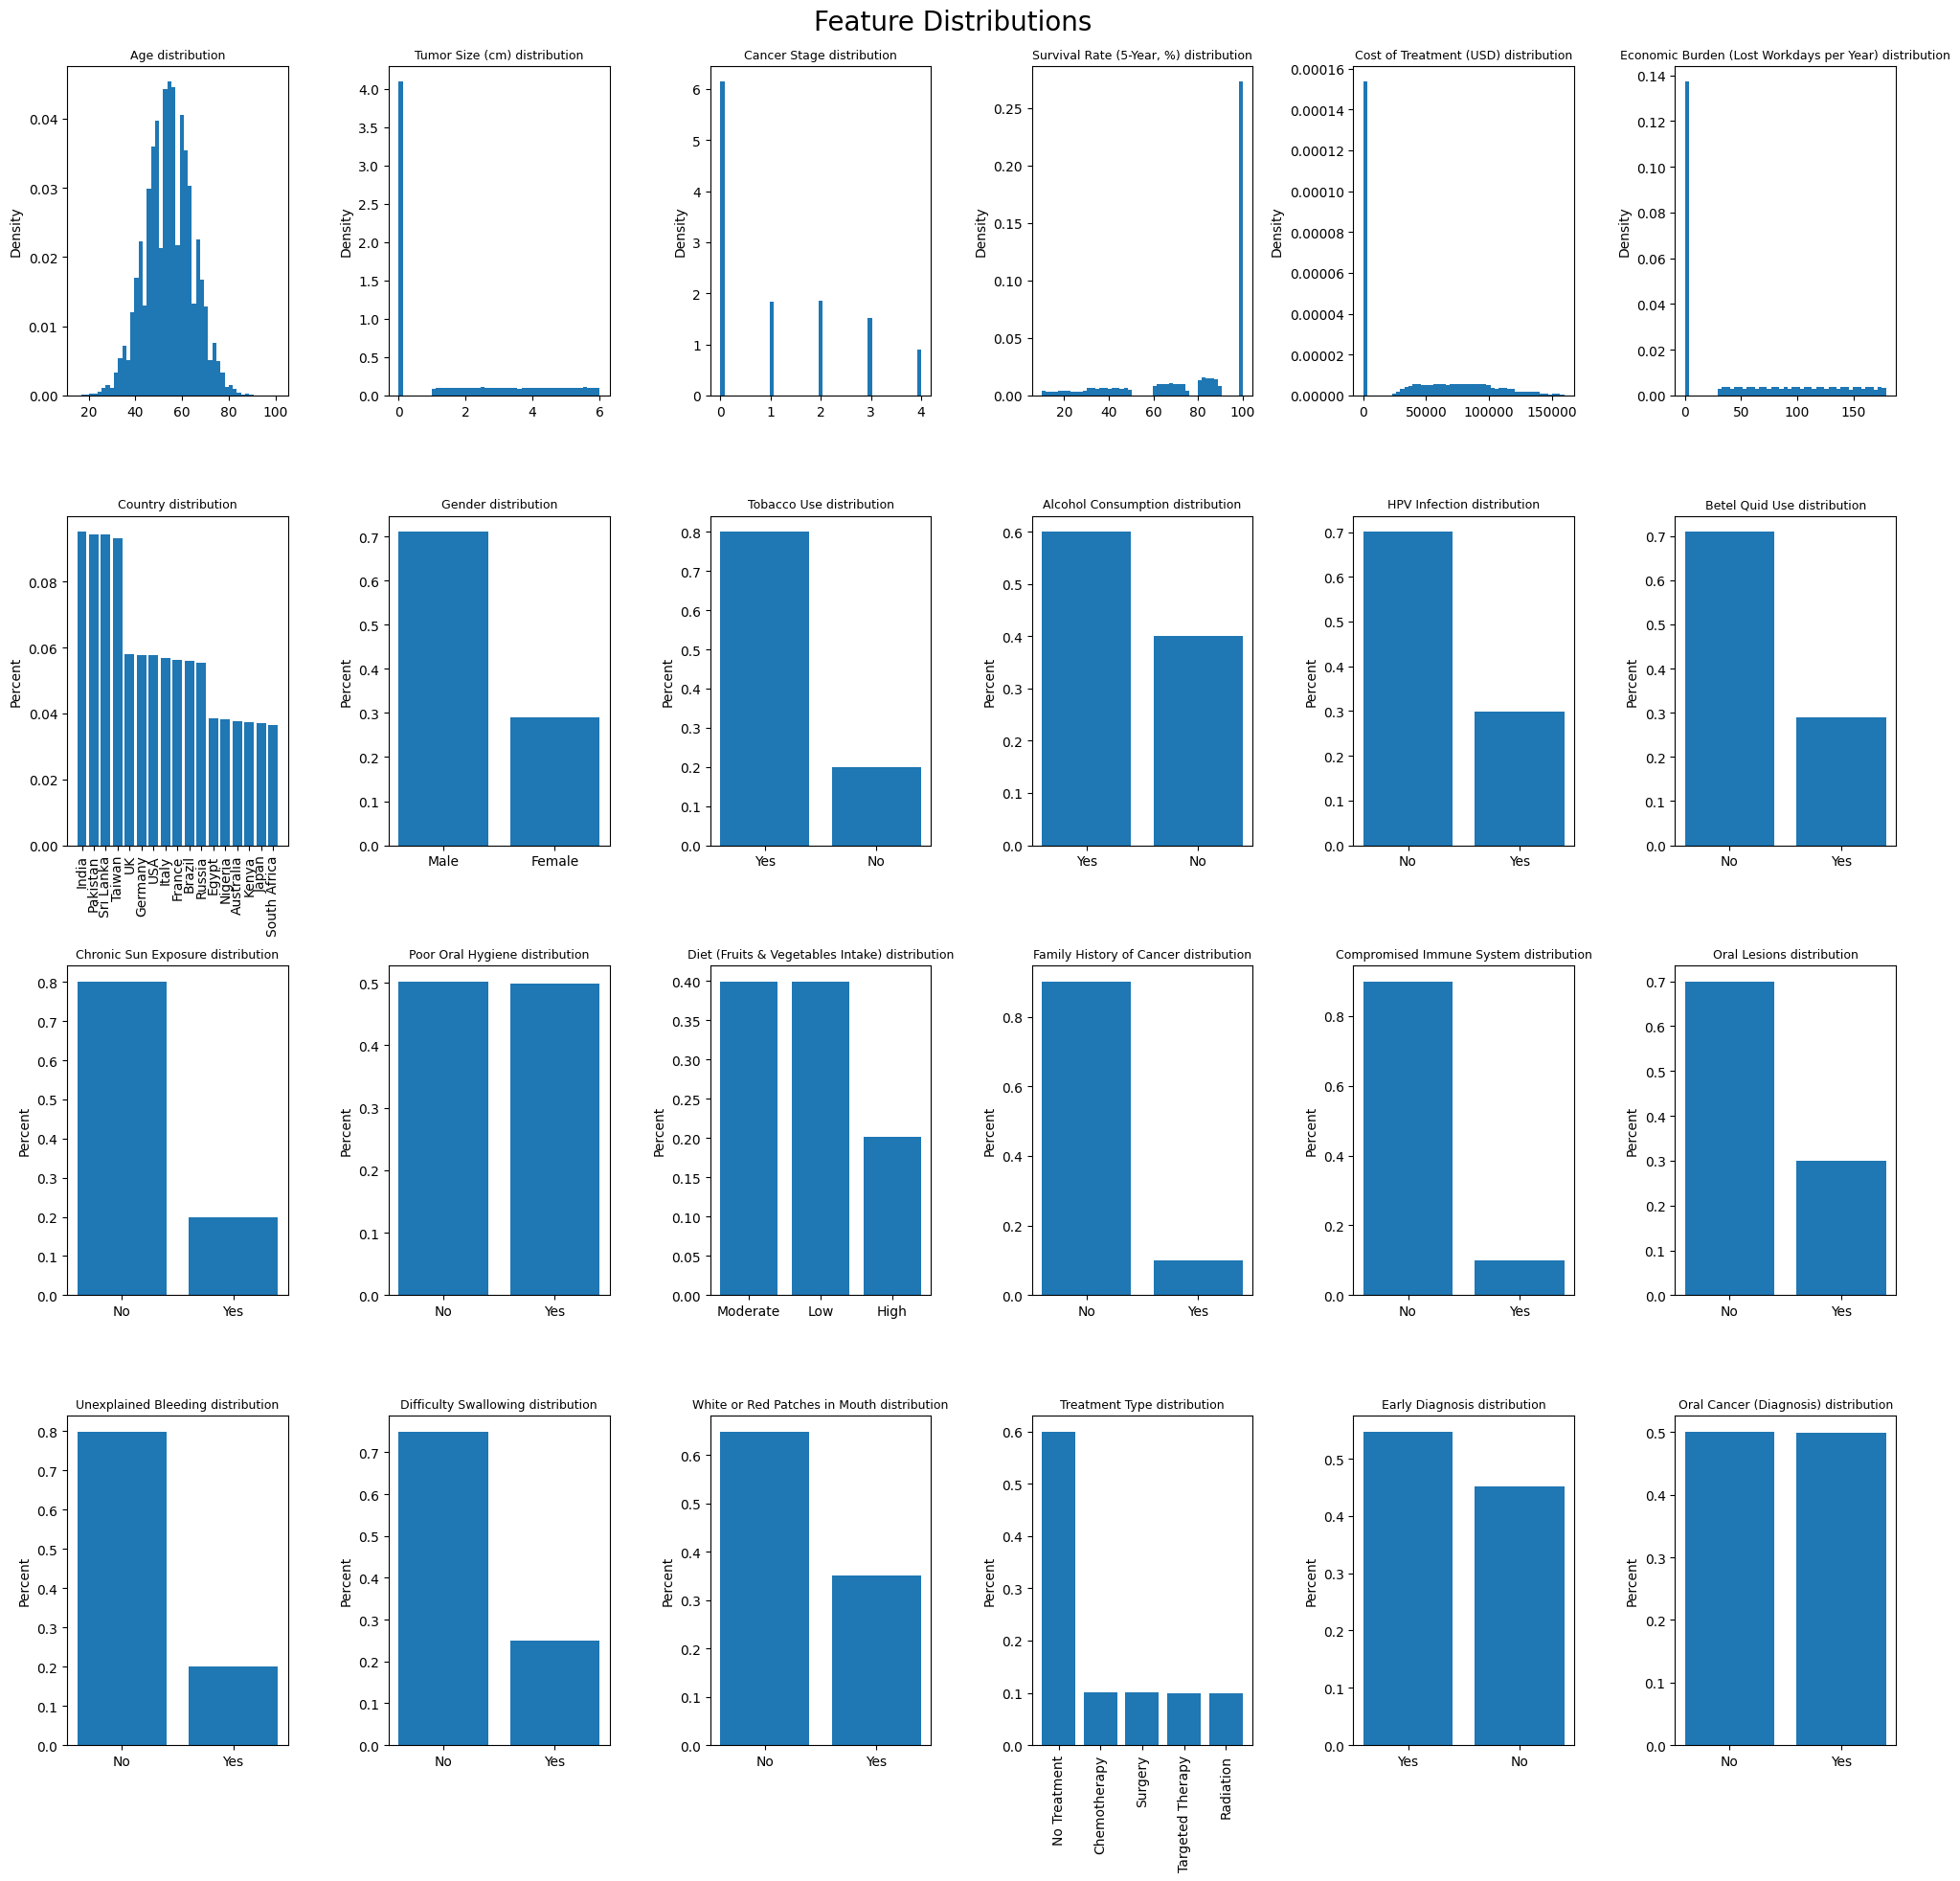

In [6]:
def eda_plots(df):

    df = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns
    categorical_cols = df.select_dtypes(exclude='number').columns

    total_plots = df.shape[1]
    nrows = int(np.floor(np.sqrt(df.shape[1])))
    ncols = int(np.ceil(df.shape[1]/nrows))


    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
    fig.subplots_adjust(wspace=0.3, hspace=0.5)
    fig.suptitle('Feature Distributions', fontsize=20)
    axs = axs.flatten()

    plot_idx = 0
    for col in numeric_cols:
        
        all_values = df[col].dropna().values
        if len(all_values) > 0:

                    min_val = np.min(all_values)
                    max_val = np.max(all_values)
                    
                    if min_val == max_val:
                        min_val -= 0.1
                        max_val += 0.1
                        
                    bin_count = min(50, max(10, int(np.sqrt(len(all_values)))))
                    bins = np.linspace(min_val, max_val, bin_count)

        axs[plot_idx].hist(df[col], bins=bins, density=True)
        axs[plot_idx].set_ylabel('Density')
        axs[plot_idx].set_title(f'{col} distribution', fontsize=9)
        plot_idx += 1

    for col in categorical_cols:
        value_counts = df[col].value_counts()

        axs[plot_idx].bar(x=value_counts.index, height=value_counts.values/len(df))
        if col == 'Country' or col == 'Treatment Type':
            axs[plot_idx].tick_params(axis='x', rotation=90)
        axs[plot_idx].set_ylabel('Percent')
        axs[plot_idx].set_title(f'{col} distribution', fontsize=9)
        plot_idx += 1
        
    for i in range(plot_idx, len(axs)):
        axs[i].axis('off')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
        
    return None

eda_plots(df_full)

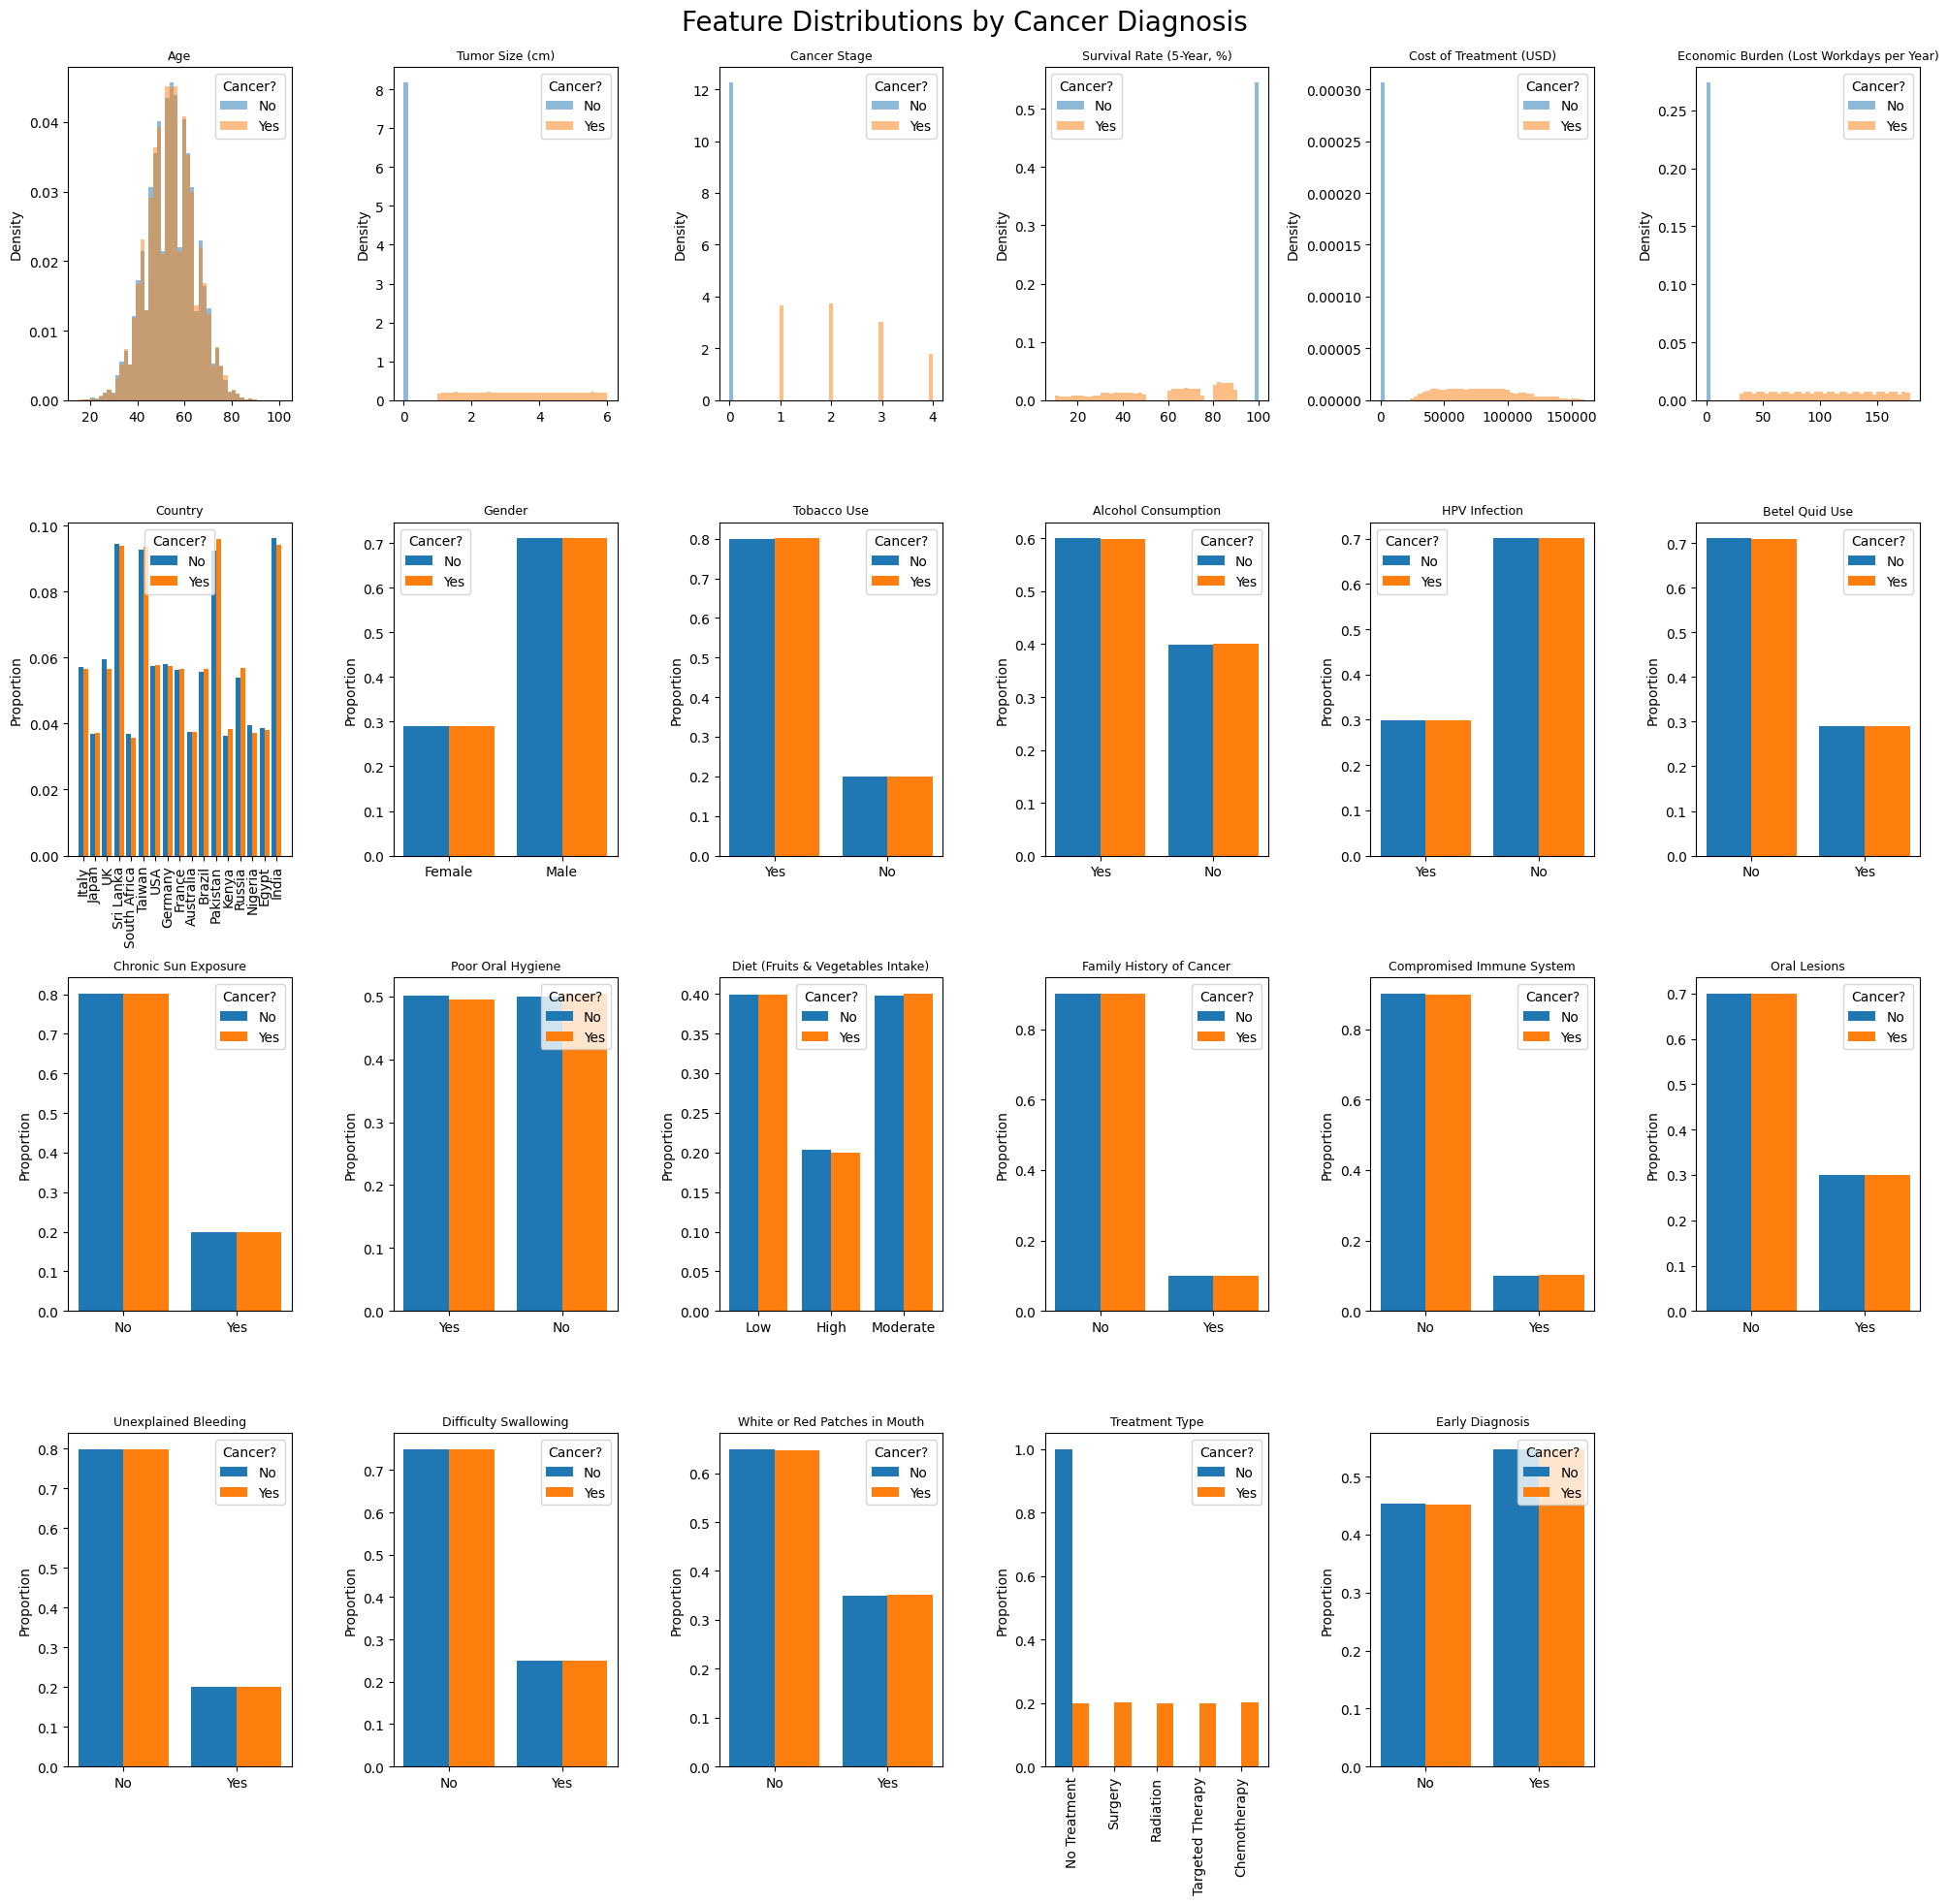

In [7]:
def eda_plots_by_diagnosis(df, target_col):

    df = df.copy()

    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    categorical_cols = df.select_dtypes(exclude='number').columns.tolist()
    if target_col in categorical_cols:
        categorical_cols.remove(target_col)
    

    target_values = df[target_col].unique()
    
    total_plots = df.shape[1]
    nrows = int(np.floor(np.sqrt(df.shape[1])))
    ncols = int(np.ceil(df.shape[1]/nrows))


    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
    fig.subplots_adjust(wspace=0.3, hspace=0.5)
    fig.suptitle('Feature Distributions by Cancer Diagnosis', fontsize=20)
    axs = axs.flatten()

    plot_idx = 0
    
    for col in numeric_cols:
        
        all_values = df[col].dropna().values
        if len(all_values) > 0:

                    min_val = np.min(all_values)
                    max_val = np.max(all_values)
                    
                    if min_val == max_val:
                        min_val -= 0.1
                        max_val += 0.1
                        
                    bin_count = min(50, max(10, int(np.sqrt(len(all_values)))))
                    bins = np.linspace(min_val, max_val, bin_count)
        
        for target_value in target_values:
            subset = df[df[target_col] == target_value]
            axs[plot_idx].hist(subset[col], bins=bins, density=True, alpha=0.5, label=f'{target_value}')
        
        axs[plot_idx].set_ylabel('Density')
        axs[plot_idx].set_title(col, fontsize=9)
        axs[plot_idx].legend(title='Cancer?')

        plot_idx += 1
    
    for col in categorical_cols:

        categories = df[col].unique()
        x = np.arange(len(categories))
        w = 0.4
        
        for i, target_value in enumerate(target_values):
            subset = df[df[target_col] == target_value]
            counts = pd.Series(0, index=categories)
            counts.update(subset[col].value_counts())

            
            axs[plot_idx].bar(x + (i-0.5)*w, counts.values/len(subset), w, label=f'{target_value}')

            axs[plot_idx].set_title(col, fontsize=9)
            axs[plot_idx].set_xticks(x)
            axs[plot_idx].set_ylabel('Proportion')
            axs[plot_idx].set_xticklabels(categories)
            axs[plot_idx].legend(title='Cancer?')
            
            if col == 'Country' or col == 'Treatment Type':
                axs[plot_idx].tick_params(axis='x', rotation=90)
            
        plot_idx += 1
        
    for i in range(plot_idx, len(axs)):
        axs[i].axis('off')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
        
    return None

eda_plots_by_diagnosis(df_full, target_col='Oral Cancer (Diagnosis)' )

## 5. Data Preprocessing

In this section, the categorical features are binary encoded and the numeric features are scaled using the min-max method.

In [8]:
# Data preprocessing class
class Preprocessor():
    def __init__(self):
        self.categorical_features = None
        self.numeric_features = None
        self.encoders = {}
        self.scaler = MinMaxScaler()
    
    def fit(self, df, y=None):
        df = pd.DataFrame(df.copy())
        
        self.categorical_features = df.select_dtypes(include=['object']).columns.tolist()
        self.numeric_features = df.select_dtypes(include=['number']).columns.tolist()
        
        for col in self.categorical_features:
            self.encoders[col] = LabelEncoder()
            self.encoders[col].fit(df[col].astype(str))
        
        if self.numeric_features:
            self.scaler.fit(df[self.numeric_features])
        
        return self
    
    def transform(self, df, y=None):
        df_transformed = pd.DataFrame(df.copy())

        for col in self.categorical_features:
            if col in df_transformed.columns:
                df_transformed[col] = self.encoders[col].transform(df_transformed[col].astype(str))
        
        if self.numeric_features:
            numeric_cols = [col for col in self.numeric_features if col in df_transformed.columns]
            if numeric_cols:
                df_transformed[numeric_cols] = self.scaler.transform(df_transformed[numeric_cols])
        
        return df_transformed
    
    def fit_transform(self, df, y=None):
        self.fit(df)
        return self.transform(df)

In [9]:
# Prepare data for modeling
le = LabelEncoder()
target = le.fit_transform(df_full['Oral Cancer (Diagnosis)'])

features_full = df_full.drop('Oral Cancer (Diagnosis)', axis=1)
features_clean = df_clean.drop('Oral Cancer (Diagnosis)', axis=1)

# Split data with stratification 
X_train, X_test, y_train, y_test = train_test_split(
    features_full, target, test_size=0.20, random_state=42, shuffle=True, stratify=target
)

X_train_clean = features_clean.loc[X_train.index]
X_test_clean = features_clean.loc[X_test.index]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 67937 samples
Test set size: 16985 samples


## 6. Simulating Real-World Class Imbalance

Using scale_pos_weight of approximately 25,000 allows us to simulate real-world oral cancer prevalence (about 4 in 100000). This adjustment helps demonstrate how model performance metrics would be affected in realistic scenarios where there is a large class imbalance between positive and negative diagnoses. This approach is preferred over resampling techniques like SMOTE for demonstrating prevalence effects because this dataset requires positive targets to be downsampled, and XGBoost has a convenient class weighting parameter.

In [10]:
# Calculate scale_pos_weight for real-world prevalence (approximately 4 per 100,000)
real_prevalence = 4/100000
current_prevalence = sum(y_train)/len(y_train)
scale_pos_weight_value = (1-real_prevalence)/real_prevalence

print(f"Using scale_pos_weight: {scale_pos_weight_value} to simulate real-world prevalence")

Using scale_pos_weight: 24998.999999999996 to simulate real-world prevalence


## 7. Model Building

This section builds a scikit-learn pipeline class to create a streamlined modeling workflow.

In [11]:
# Create pipelines for each experiment
pipeline_with_leakage = Pipeline([
    ('preprocessor', Preprocessor()),
    ('feature_selection', SelectKBest(f_classif, k=10)),
    ('model', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

pipeline_no_leakage = Pipeline([
    ('preprocessor', Preprocessor()),
    ('feature_selection', SelectKBest(f_classif, k=10)),
    ('model', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

pipeline_realistic = Pipeline([
    ('preprocessor', Preprocessor()),
    ('feature_selection', SelectKBest(f_classif, k=10)),
    ('model', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_value))
])

In [12]:
# Fit models
pipeline_with_leakage.fit(X_train, y_train)
pipeline_no_leakage.fit(X_train_clean, y_train)
pipeline_realistic.fit(X_train_clean, y_train)

Pipeline(steps=[('preprocessor',
                 <__main__.Preprocessor object at 0x7ef51618e6e0>),
                ('feature_selection', SelectKBest()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=N...ow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## 8. Cross Validation

Cross-validation results show drastically different performance across the three experimental conditions. The model with post-diagnostic features achieves near-perfect scores with accuracy, precision, and recall all close to 1. This demonstrates how significantly data leakage can affect model performance, casuing to misleading results as performance drops significantly when leakage features are removed. With realistic class imbalance, performance metrics drop even further, particularly recall, because the simulated lack of positively diagnosed patients limits predictive power. These differences highlight how data quality issues can lead to inflated performance metrics overall.


In [13]:
# Cross-validation function
def perform_cross_validation(X, y, pipeline, cv=5):

    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    cv_results = cross_validate(
        pipeline, X, y,
        cv=skf,
        scoring=scoring,
        return_train_score=False
    )
    
    # Calculate mean and std for each metric
    results = {}
    for metric in scoring.keys():
        results[metric] = {
            'mean': cv_results[f'test_{metric}'].mean(),
            'std': cv_results[f'test_{metric}'].std()
        }
    
    return results

In [14]:
# Apply cross-validation to each experiment
cv_results_leakage = perform_cross_validation(
    X_train, y_train, pipeline_with_leakage
)

cv_results_no_leakage = perform_cross_validation(
    X_train_clean, y_train, pipeline_no_leakage
)

cv_results_realistic = perform_cross_validation(
    X_train_clean, y_train, pipeline_realistic
)

In [15]:
# Summarize
cv_summary = pd.DataFrame({
    'With Leakage': {f"{metric}": f"{results['mean']} ± {results['std']}" 
                    for metric, results in cv_results_leakage.items()},
    'Without Leakage': {f"{metric}": f"{results['mean']} ± {results['std']}" 
                       for metric, results in cv_results_no_leakage.items()},
    'Realistic': {f"{metric}": f"{results['mean']} ± {results['std']}" 
                 for metric, results in cv_results_realistic.items()}
})

print("\nCross-validation results (mean ± std):")
print(cv_summary)


Cross-validation results (mean ± std):
          With Leakage                             Without Leakage  \
accuracy     1.0 ± 0.0  0.4982262359262658 ± 0.0038021396794904448   
precision    1.0 ± 0.0   0.4967510449090359 ± 0.003925860603805821   
recall       1.0 ± 0.0   0.4697306752288302 ± 0.017004913443228423   
f1           1.0 ± 0.0     0.48269793315638293 ± 0.009281460873091   
roc_auc      1.0 ± 0.0   0.5002093042081748 ± 0.004602663643919007   

                                             Realistic  
accuracy   0.49868260321478663 ± 0.0001172962853647746  
precision    0.498682525199578 ± 7.137182361040617e-05  
recall      0.999940959409594 ± 0.00011808118081182428  
f1          0.6654814729519403 ± 8.641975272273481e-05  
roc_auc     0.5012961605821056 ± 0.0035852431448081946  


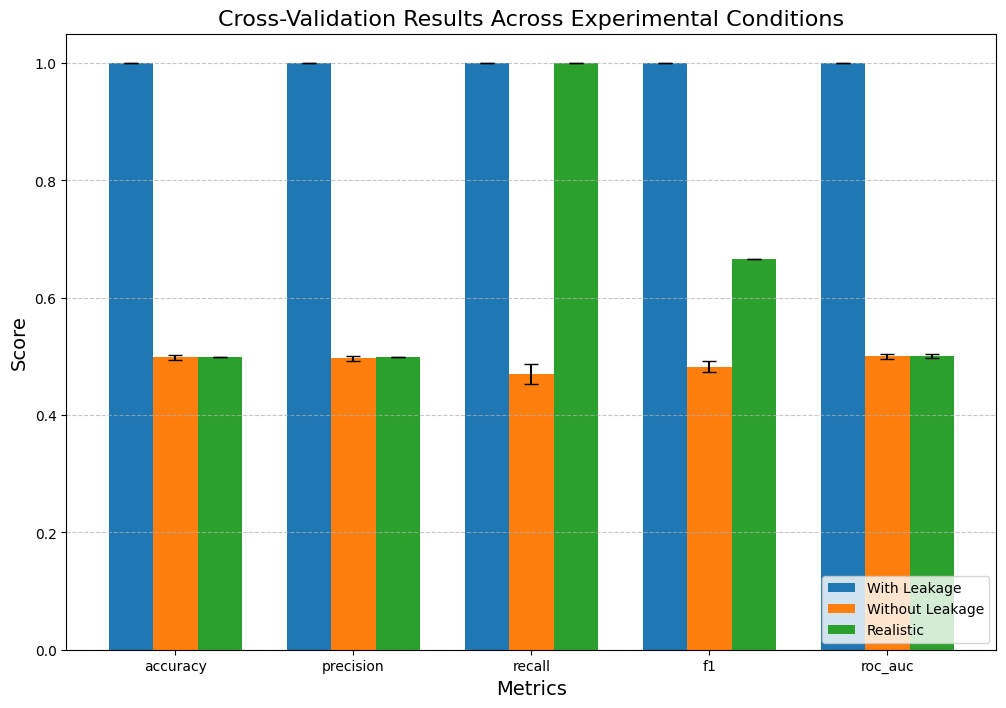

In [16]:
# Visualize cross-validation results
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
conditions = ['With Leakage', 'Without Leakage', 'Realistic']

plt.figure(figsize=(12, 8))
x = np.arange(len(metrics))
width = 0.25


for i, condition in enumerate(conditions):
    if condition == 'With Leakage':
        results = cv_results_leakage
    elif condition == 'Without Leakage':
        results = cv_results_no_leakage
    else:
        results = cv_results_realistic
    
    means = [results[metric]['mean'] for metric in metrics]
    stds = [results[metric]['std'] for metric in metrics]
    
    plt.bar(x + (i - 1) * width, means, width, label=condition,
            yerr=stds, capsize=5)

plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Cross-Validation Results Across Experimental Conditions', fontsize=16)
plt.xticks(x, metrics)
plt.legend(loc='lower right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# Make predictions
y_pred_leakage = pipeline_with_leakage.predict(X_test)
y_proba_leakage = pipeline_with_leakage.predict_proba(X_test)[:, 1]

y_pred_no_leakage = pipeline_no_leakage.predict(X_test_clean)
y_proba_no_leakage = pipeline_no_leakage.predict_proba(X_test_clean)[:, 1]

y_pred_realistic = pipeline_realistic.predict(X_test_clean)
y_proba_realistic = pipeline_realistic.predict_proba(X_test_clean)[:, 1]

## 9. Model Evaluation

ROC curves demonstrate the difference in model performance across experiments. The feature importance plots reveal how leakage features dominated the model with data leakage, as expected. In the clean model, legitimate predictive features like lifestyle factors and symptoms become more important. The realistic model shows greater reliance on a smaller set of highly predictive features. These results demonstrate how data quality impacts not just model performance but also feature importance and interpretation.


In [18]:
# Function for comprehensive model evaluation
def evaluate_model(y_true, y_pred, y_proba, title):

    print(f"\n{title}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Create confusion matrix 
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=['Negative', 'Positive'],
        cmap='Blues',
        values_format='d'
    )
    plt.title(f"Confusion Matrix - {title}")
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba)
    }
    
    print("\nKey Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics


XGBoost with Leakage Features

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8515
           1       1.00      1.00      1.00      8470

    accuracy                           1.00     16985
   macro avg       1.00      1.00      1.00     16985
weighted avg       1.00      1.00      1.00     16985



<Figure size 800x600 with 0 Axes>

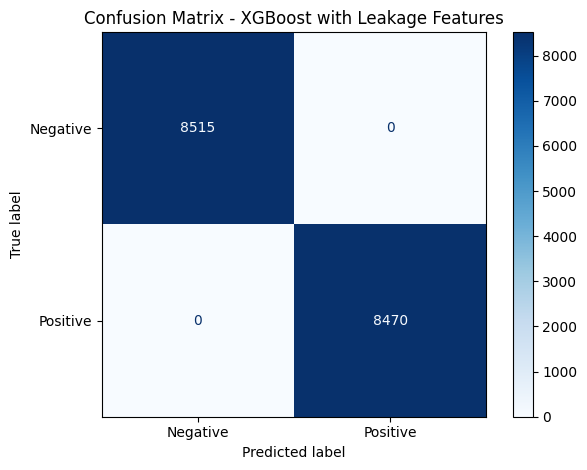


Key Metrics:
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
roc_auc: 1.0000

XGBoost without Leakage Features

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.53      0.52      8515
           1       0.50      0.47      0.48      8470

    accuracy                           0.50     16985
   macro avg       0.50      0.50      0.50     16985
weighted avg       0.50      0.50      0.50     16985



<Figure size 800x600 with 0 Axes>

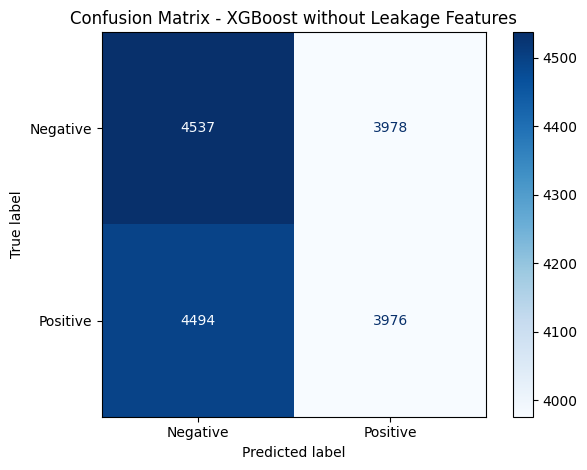


Key Metrics:
accuracy: 0.5012
precision: 0.4999
recall: 0.4694
f1: 0.4842
roc_auc: 0.5011

XGBoost with Realistic Class Imbalance

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8515
           1       0.50      1.00      0.67      8470

    accuracy                           0.50     16985
   macro avg       0.25      0.50      0.33     16985
weighted avg       0.25      0.50      0.33     16985



<Figure size 800x600 with 0 Axes>

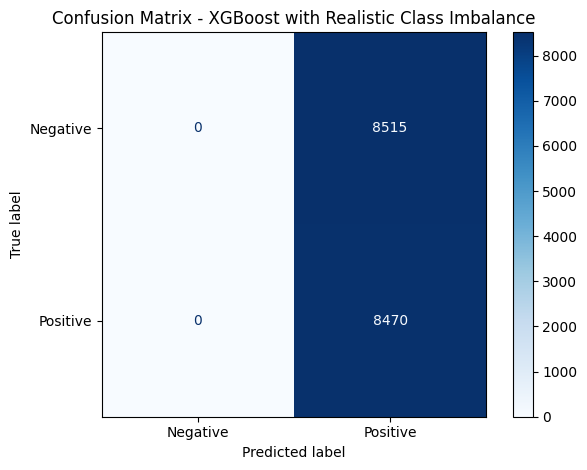


Key Metrics:
accuracy: 0.4987
precision: 0.4987
recall: 1.0000
f1: 0.6655
roc_auc: 0.5018

Summary of model performance across experiments:
           With Leakage  Without Leakage  Realistic
accuracy            1.0         0.501207   0.498675
precision           1.0         0.499874   0.498675
recall              1.0         0.469421   1.000000
f1                  1.0         0.484170   0.665488
roc_auc             1.0         0.501093   0.501789


In [19]:
# Evaluate each model
results = {}
results['With Leakage'] = evaluate_model(
    y_test, y_pred_leakage, y_proba_leakage, 
    "XGBoost with Leakage Features"
)

results['Without Leakage'] = evaluate_model(
    y_test, y_pred_no_leakage, y_proba_no_leakage, 
    "XGBoost without Leakage Features"
)

results['Realistic'] = evaluate_model(
    y_test, y_pred_realistic, y_proba_realistic, 
    "XGBoost with Realistic Class Imbalance"
)

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results)
print("\nSummary of model performance across experiments:")
print(results_df)

<Figure size 1000x800 with 0 Axes>

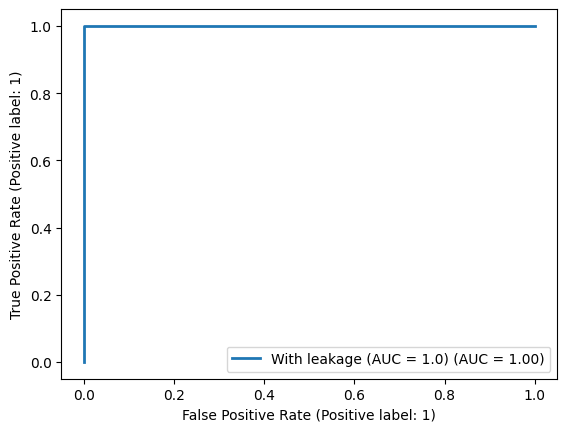

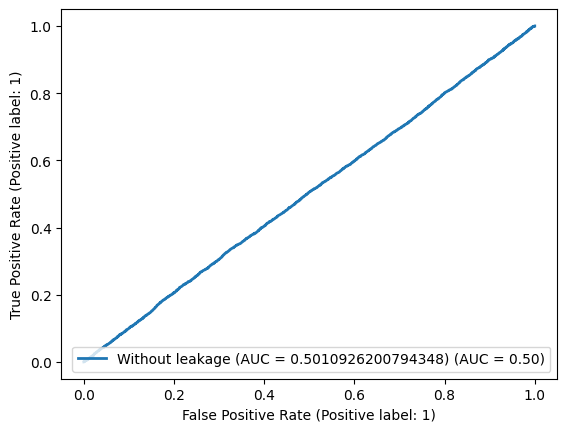

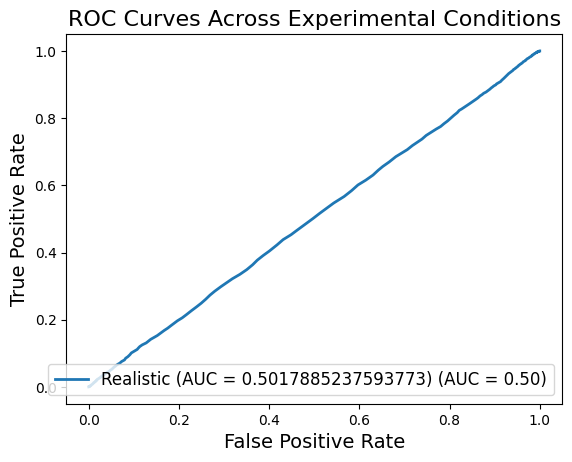

In [20]:
# Plot ROC curves for comparison
plt.figure(figsize=(10, 8))

RocCurveDisplay.from_predictions(
    y_test, y_proba_leakage,
    name=f'With leakage (AUC = {results["With Leakage"]["roc_auc"]})',
    lw=2
)

RocCurveDisplay.from_predictions(
    y_test, y_proba_no_leakage,
    name=f'Without leakage (AUC = {results["Without Leakage"]["roc_auc"]})',
    lw=2
)

RocCurveDisplay.from_predictions(
    y_test, y_proba_realistic,
    name=f'Realistic (AUC = {results["Realistic"]["roc_auc"]})',
    lw=2
)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves Across Experimental Conditions', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [21]:
def plot_feature_importance(pipeline, X, feature_names, title):

    # Get the model from the pipeline
    model = pipeline.named_steps['model']
    
    X_processed = pipeline[:-1].transform(X)
    
    selected_indices = pipeline.named_steps['feature_selection'].get_support()
    selected_features = feature_names[selected_indices]
    
    # Get feature importance from the model
    importances = model.feature_importances_
    
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [selected_features[i] for i in indices], rotation=90)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

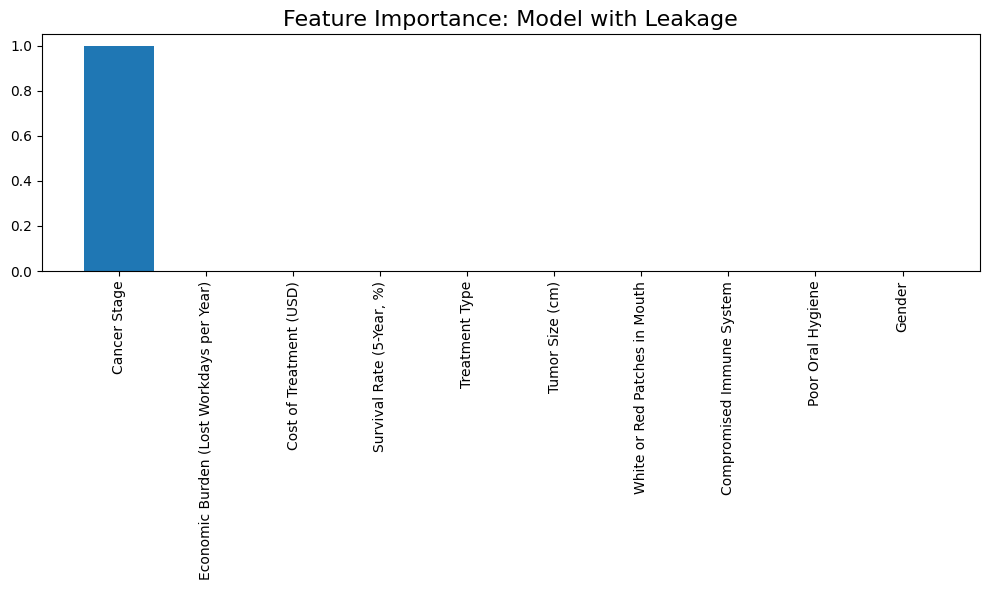

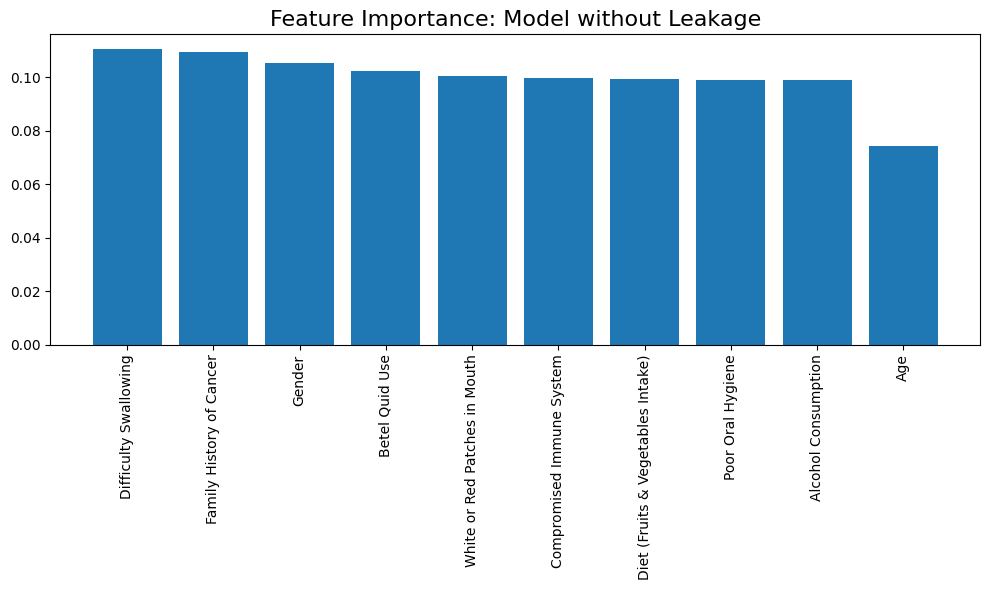

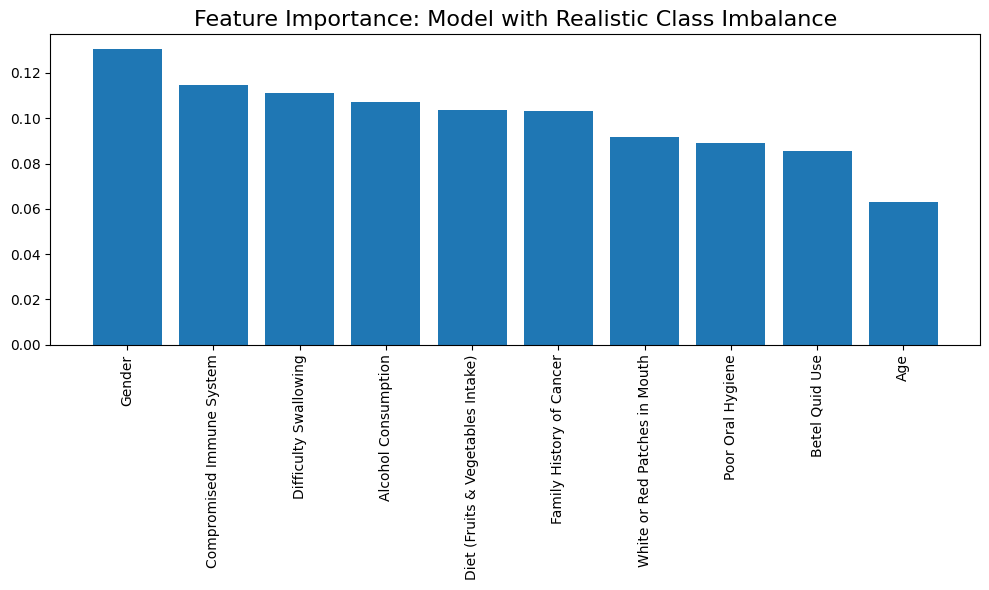

In [22]:
# Plot feature importance for all models
plot_feature_importance(
    pipeline_with_leakage, 
    X_test, 
    np.array(X_train.columns), 
    "Feature Importance: Model with Leakage"
)

plot_feature_importance(
    pipeline_no_leakage, 
    X_test_clean, 
    np.array(X_train_clean.columns), 
    "Feature Importance: Model without Leakage"
)

plot_feature_importance(
    pipeline_realistic, 
    X_test_clean, 
    np.array(X_train_clean.columns), 
    "Feature Importance: Model with Realistic Class Imbalance"
)

## 10. Conclusion

The analysis above demonstrates the impact of data quality on healthcare machine learning models. Experimenting with post-diagnosis features and simulated class imbalance revealed important implications for medical predictive modeling. 

First, data leakage from post-diagnosis features artificially inflated model performance metrics to perfect levels. When these features that would not be avialable pre-diagnosis in realistic situations were removed, performance dropped substantially.

Second, the unrealistically balanced dataset with a 50/50 positive/negative split created expectations about model performance for a rare condition that do not align with reality. After adjusting the classification weights to reflect real-world global oral cancer prevalence of approximately 4 in 100,000, performance metrics worsened as expected.

Finally, the feature importance analysis revealed how leakage features dominated the model's decision-making when included. After removing these problematic features, predictors like tobacco use and oral symptoms emerged as significant, as we would expect in real clinical data. 

The findings in this notebook showcase why careful evaluation of healthcare datasets is essential before building predictive models. Although this dataset says it is for use by medical professionals, it is entirely misleading in terms of clinical value. Furthermore, this project shows how critical domain knowledge is when developing a model in any industry. Many models built using this dataset reported 100% accuracy, but failed to be critical of whether the data had integrity and reflected clinical prevalence. In real-world applications, failing to address these data quality concerns could lead to misleading model evaluations and potentially harmful clinical decisions. 